In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import shutil
import os

excel_reports = ".\Excel reports"
saved_models = ".\Saved models"
trained_models = ".\Trained models"
ticker = 'nvda'

#Delete folders
# shutil.rmtree(excel_reports)
# shutil.rmtree(saved_models)
# shutil.rmtree(trained_models)

#Create folder, if exist pass exception
try:
    os.mkdir("Excel reports")
    os.mkdir("Saved models")
    os.mkdir("Trained models")
except:
    pass


In [3]:
from transformers import PullData

#Initiate parameters
window_size = 25
formation_window = 24
target_window = 1

start_date = '2020-01-01'
end_date = '2022-08-17'

GetData = PullData()

GetData.fit(ticker=ticker,
            start_date=start_date, 
            end_date=end_date, 
            interval='1wk',
            progress=False,
            condition=False,
            form_window=formation_window,
            target_window=target_window,
            timeperiod1=6,
            timeperiod2=12,
            timeperiod3=24,
            export_excel=True,
            excel_path = excel_reports
            )

data_prep = GetData.transform()




--------> PullData completed



In [4]:
####################################################################

from transformers import NormalizeData

NormalizeData = NormalizeData()

NormalizeData.fit(window_size=25, shuffle=False, debug=False,export_excel = True, excel_path = excel_reports)

data_normalized, Dates = NormalizeData.transform(data_prep)

#Get only forecasts for model testing
# x_valid_x = data_normalized[['maxv','minv']].copy() #extreme values for reverting normalization
# x_valid = data_normalized.iloc[:,:-2].copy() #dataset for forecast

Dataframe shape:  (2825, 9)
Number of formations:  113
--------> NormalizeData completed



In [5]:
####################################################################

from training import SplitData

split_ratio = 0.80

SplitData = SplitData()

SplitData.fit(split_ratio=split_ratio, window_size=25,
              dates=Dates, debug=False, export_excel=True)

x_train, x_valid, x_train_x, x_valid_x = SplitData.transform(data_normalized)



Split ratio: 80 %
train period: 2019-12-30 - 2022-02-21
valid period: 2021-09-20 - 2022-08-01
x_train window:  90.0
x_valid window:  23.0
--------> SplitData completed



In [6]:
from training import GetTensoredDataset

GetTensoredDataset = GetTensoredDataset()

GetTensoredDataset.fit(window_size=25, batch_size=8, train=True, debug=False)

x_train_tensors, _ = GetTensoredDataset.transform(x_train)
c = 0

for batch in x_train_tensors:
    if c < 3:
        print(batch)
    else:
        break

--------> GetTensoredDataset completed

(<tf.Tensor: shape=(8, 24, 7), dtype=float64, numpy=
array([[[0.25195665, 0.29716039, 0.24809357, ..., 0.32116699,
         0.3623027 , 0.50274895],
        [0.25908094, 0.34050777, 0.25381301, ..., 0.32116699,
         0.3623027 , 0.50274895],
        [0.33604259, 0.36278351, 0.32033917, ..., 0.32116699,
         0.3623027 , 0.50274895],
        ...,
        [0.93111574, 0.9361328 , 0.69832429, ..., 0.74148883,
         0.62341116, 0.50274895],
        [0.866195  , 0.89905682, 0.83102553, ..., 0.78209322,
         0.66344086, 0.50274895],
        [0.87502507, 1.        , 0.83659439, ..., 0.81181308,
         0.69769807, 0.50274895]],

       [[0.25187791, 0.33104089, 0.24675645, ..., 0.31223783,
         0.35222988, 0.48877141],
        [0.32669986, 0.35269733, 0.31143303, ..., 0.31223783,
         0.35222988, 0.48877141],
        [0.32743146, 0.3844503 , 0.32138332, ..., 0.31223783,
         0.35222988, 0.48877141],
        ...,
        [0.8421

In [7]:
from training import GetTensoredDataset

GetTensoredValidDataset = GetTensoredDataset()

GetTensoredValidDataset.fit(
    window_size=25, batch_size=2, train=False, debug=False)

x_valid_tensors, labels = GetTensoredValidDataset.transform(x_valid)

for batch in x_valid_tensors:
    if c < 3:
        print(batch)
    else:
        break

--------> GetTensoredDataset completed

(<tf.Tensor: shape=(2, 24, 7), dtype=float64, numpy=
array([[[0.12665721, 0.21650782, 0.0953485 , 0.18713975, 0.17121167,
         0.11192988, 0.        ],
        [0.16314083, 0.16889799, 0.06565706, 0.1005235 , 0.15101505,
         0.11017505, 0.00804188],
        [0.0851279 , 0.13804213, 0.02373974, 0.10628066, 0.1382338 ,
         0.10957591, 0.01590098],
        [0.08972074, 0.17743666, 0.08558075, 0.17297322, 0.14815935,
         0.11932935, 0.02846676],
        [0.16566363, 0.25499673, 0.15887144, 0.22886302, 0.17121754,
         0.13618068, 0.04449846],
        [0.24484078, 0.42182515, 0.23170927, 0.41263957, 0.24019526,
         0.17871282, 0.07394975],
        [0.41794388, 0.78996043, 0.39064594, 0.68335574, 0.36681254,
         0.25635019, 0.12270223],
        [0.70903659, 0.84882588, 0.6203504 , 0.72462625, 0.46904503,
         0.32839266, 0.17085615],
        [0.73510555, 0.89915257, 0.62177353, 0.89248979, 0.59002925,
         0.415

<b>Model Training</b>

In [9]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint


model_name = f'{saved_models}/{str.upper(ticker)}_{formation_window}_{target_window}_{window_size}_{split_ratio}_{start_date}_{end_date}.h5'

early_stopping = EarlyStopping(
    monitor='val_loss', patience=6, mode='min', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=10e-15,
                              verbose=1)

model_checkpoint = ModelCheckpoint(monitor='val_loss',
                                   filepath=model_name,
                                   save_best_only=True)

callbacks = [early_stopping, reduce_lr, model_checkpoint]


def sign_penalty(y_true, y_pred):
    penalty = 100.
    loss = tf.where(tf.less(y_true*y_pred, 0),
                    penalty * tf.square(y_true-y_pred),
                    tf.square(y_true - y_pred)
                    )

    return(tf.reduce_mean(loss, axis=-1))


tf.keras.losses.sign_penalty = sign_penalty


Model 1

In [7]:
# def ModelGeneral():
# #tf.random.set_seed(7788)

#     # model = tf.keras.models.Sequential([

#     #     tf.keras.layers.Conv1D(filters=256, kernel_size=10,
#     #                     strides=1, padding="same",
#     #                     activation=tf.nn.selu,
#     #                     input_shape=[None, 7]),
#     # #     tf.keras.layers.Conv1D(filters=512, kernel_size=10,
#     # #                       strides=1, padding="same",
#     # #                       activation=tf.nn.selu,
#     # #                       input_shape=[None, 7]),

#     #     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
#     #     #tf.keras.layers.Dropout(0.2),
#     #     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
#     #     #tf.keras.layers.Dropout(0.2),
#     #     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
#     #     #tf.keras.layers.Dropout(0.2),
#     #     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
#     #     # tf.keras.layers.Dropout(0.2),
#     #     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
#     #     #tf.keras.layers.Dropout(0.2),
#     #     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
#     #     #tf.keras.layers.Dropout(0.2),
#     #     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
#     #     #tf.keras.layers.Dropout(0.2),
#     #     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
#     #     #tf.keras.layers.Dropout(0.2),
#     #     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
#     #     #tf.keras.layers.Dropout(0.2),
#     #     tf.keras.layers.Dense(1024, activation=tf.nn.selu),
#     #     #tf.keras.layers.Dropout(0.2),
#     #     tf.keras.layers.Dense(1024, activation=tf.nn.selu),
#     #     #tf.keras.layers.Dropout(0.2),
#     #     tf.keras.layers.Dense(1024, activation=tf.nn.selu),
#     #     #tf.keras.layers.Dropout(0.2),
#     #     tf.keras.layers.Dense(1024, activation=tf.nn.selu),
#     #     #tf.keras.layers.Dropout(0.2),
#     #     tf.keras.layers.Dense(16, activation=tf.nn.selu),
#     #     tf.keras.layers.Dense(16, activation=tf.nn.selu),
#     #     tf.keras.layers.Dense(4, activation=tf.nn.selu),
#     #     tf.keras.layers.Dense(3, activation=tf.nn.selu), #4
#     #     tf.keras.layers.Dense(1,activation=tf.nn.relu),
#     # ])

#     # #optimizer1 = tf.keras.optimizers.SGD(learning_rate=10e-7, momentum=0.9)
#     # #optimizer2 = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
#     # #optimizer3 = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False)
#     # #optimizer4 = tf.keras.optimizers.Adadelta(learning_rate=0.001, rho=0.95, epsilon=1e-07, name='Adadelta')

#     # optimizer5 = tf.keras.optimizers.Adagrad(learning_rate=0.0001, initial_accumulator_value=0.1, epsilon=1e-07,name='Adagrad')


#     # model.compile(loss=sign_penalty,
#     #             optimizer=optimizer5,
#     #             )

#     # model.fit(train_set, epochs=120,callbacks=[callbacks],validation_data=val_dataset)


Model 2

In [10]:
tf.random.set_seed(7788)
np.random.seed(7788)

model = tf.keras.models.Sequential([

    tf.keras.layers.Conv1D(filters=8, kernel_size=1,
                           strides=1, padding="same",
                           activation=tf.nn.selu,
                           input_shape=[None, 7]),
    tf.keras.layers.Conv1D(filters=16, kernel_size=1,
                           strides=1, padding="same",
                           activation=tf.nn.selu,
                           #input_shape=[None, 7]
                           ),
    tf.keras.layers.Conv1D(filters=32, kernel_size=10,
                           strides=1, padding="same",
                           activation=tf.nn.selu,
                           #input_shape=[None, 7]
                           ),

    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(9, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(9)),
    tf.keras.layers.Dense(4, activation=tf.nn.selu),
    tf.keras.layers.Dense(3, activation=tf.nn.selu),
    tf.keras.layers.Dense(2, activation=tf.nn.selu),        
    tf.keras.layers.Dense(1, activation=tf.nn.relu),
])

def mrk_model():
    model = tf.keras.models.Sequential([

    tf.keras.layers.Conv1D(filters=8, kernel_size=1,
                           strides=1, padding="same",
                           activation=tf.nn.selu,
                           input_shape=[None, 7]),
    tf.keras.layers.Conv1D(filters=16, kernel_size=1,
                           strides=1, padding="same",
                           activation=tf.nn.selu,
                           #input_shape=[None, 7]
                           ),
    tf.keras.layers.Conv1D(filters=32, kernel_size=10,
                           strides=1, padding="same",
                           activation=tf.nn.selu,
                           #input_shape=[None, 7]
                           ),

    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(9, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(9)),
    tf.keras.layers.Dense(4, activation=tf.nn.selu),
    tf.keras.layers.Dense(3, activation=tf.nn.selu),
    tf.keras.layers.Dense(2, activation=tf.nn.selu),        
    tf.keras.layers.Dense(1, activation=tf.nn.relu),
    ])
    optimizer2 = tf.keras.optimizers.Adam(
    learning_rate=0.0009, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
    optimizer5 = tf.keras.optimizers.Adagrad(
        learning_rate=0.005, initial_accumulator_value=5, epsilon=1e-07, name='Adagrad')

    model.compile(loss=sign_penalty,
                optimizer=optimizer5,
                )

    model.fit(x_train_tensors, epochs=1200, callbacks=[
            callbacks], validation_data=x_valid_tensors)
    return model

optimizer2 = tf.keras.optimizers.Adam(
    learning_rate=0.0009, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
optimizer5 = tf.keras.optimizers.Adagrad(
    learning_rate=0.005, initial_accumulator_value=5, epsilon=1e-07, name='Adagrad')

model.compile(loss=sign_penalty,
              optimizer=optimizer5,
              )

model.fit(x_train_tensors, epochs=1200, callbacks=[
          callbacks], validation_data=x_valid_tensors)


Epoch 1/1200
12/12 [==============================] - 13s 417ms/step - loss: 0.0255 - val_loss: 0.0836 - lr: 0.0050
Epoch 2/1200
12/12 [==============================] - 0s 40ms/step - loss: 0.0269 - val_loss: 0.0749 - lr: 0.0050
Epoch 3/1200
12/12 [==============================] - 1s 45ms/step - loss: 0.0264 - val_loss: 0.0724 - lr: 0.0050
Epoch 4/1200
12/12 [==============================] - 1s 43ms/step - loss: 0.0254 - val_loss: 0.0680 - lr: 0.0050
Epoch 5/1200
12/12 [==============================] - 0s 36ms/step - loss: 0.0247 - val_loss: 0.0719 - lr: 0.0050
Epoch 6/1200
11/12 [==========================>...] - ETA: 0s - loss: 0.0205
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
12/12 [==============================] - 0s 38ms/step - loss: 0.0233 - val_loss: 0.0730 - lr: 0.0050
Epoch 7/1200
12/12 [==============================] - 0s 34ms/step - loss: 0.0245 - val_loss: 0.0792 - lr: 1.0000e-03
Epoch 8/1200
11/12 [==========================>...] - ET

In [7]:
# #Model folders
# trained_models
# saved_models

# #Model name
model_name = f'{saved_models}/{str.upper(ticker)}_{formation_window}_{target_window}_{window_size}_{split_ratio}_{start_date}_{end_date}.h5'

model = tf.keras.models.load_model(model_name, custom_objects={
                                            'sign_penalty': sign_penalty})


In [11]:
def model_forecast(model, series, window_size, debug):
    """
    Get model, data and window size as an input. 
    Make prediction window is subtracted by 1, since we do not need label in window, 
    label value is skipped
    """
    c = 0

    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size-1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))

    if debug == True:
        # This block of code will print out data on which is made prediction
        for item in ds:
            c += 1
            if c < 3:
                print("\n"+str(c) + " prediction:\n ", item)
            else:
                break

    ds = ds.batch(1).prefetch(1)
    forecast = model.predict(ds)
    forecast2 = np.squeeze(forecast)
    return forecast2


forecast = model_forecast(model, x_valid, window_size=window_size, debug=False)
forecast[:2]


23/23 [==============================] - 2s 7ms/step


array([0.6238662, 0.5978768], dtype=float32)

In [9]:
# pr = x_valid.iloc[:24, :].to_numpy()
# pr = np.array([pr])
# pr = np.array([pr])
# pred = tf.data.Dataset.from_tensor_slices(pr)
# predict = model.predict(pred)
# print("Raw prediction: ", predict)


In [12]:
from transformers import ReverseNormalization

ReverseNormalization = ReverseNormalization()

ReverseNormalization.fit(forecasts=forecast, labels=labels,
                         x_valid=x_valid, x_valid_x=x_valid_x, window_size=25, debug=False)

df = ReverseNormalization.transform()
df.shape

--------> ReverseNormalization completed



(575, 9)

In [13]:
from final_evaluation import GetFinalDataframe

GetFinalDataframe = GetFinalDataframe()

GetFinalDataframe.fit(dates=Dates,
                      x_valid=x_valid)

reversed_df = GetFinalDataframe.transform(df)
#df1.head(25)


--------> GetFinalDataframe



In [14]:
from final_evaluation import GetModelPerformance

GetModelPerformance = GetModelPerformance()

GetModelPerformance.fit(acceptance=0,
                        penalization=0,
                        entry_candle='Current Open',
                        budget=10000,
                        window_size=25,
                        export_excel=True,
                        excel_path = excel_reports)

trades_df = GetModelPerformance.transform(reversed_df)
#trades_df.shape


period: 2021-09-20 - 2022-08-01
Formations:  23
Entry Candle:  Current Open

Total Trades:  23
Profit Trades:  12
Loss Trades:  11

Win Ratio: 52.0 %
Loss Ratio: 48 %

Average profit per trade:  382

Gross profit:  8787
Gross loss:  -6814

Net profit:  1973


In [13]:
trade = 1
budget = 10000
entry_candle = 'Current Open'

Trade:  15
Period: 2022-01-03 - 2022-06-13

Budget:  10000

Entry price:  86.05
Label (target):  95.72
Model prediction:  91.55
Market Change: 5.5 $
Profit: 639.16 $


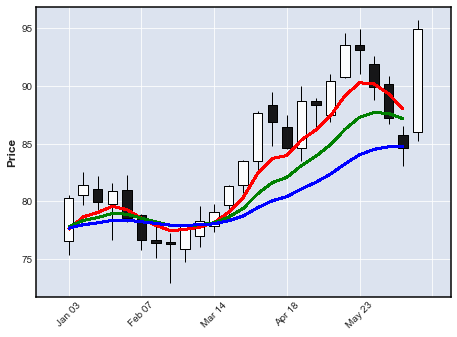

,Open,High,Low,Close,EMA6,EMA12,EMA24,labels,prediction,Datetime,profit,trade
In,,,,,,,,,,,,
425,76.580002,80.529999,75.349998,80.300003,77.562326,77.783698,77.671197,nn,nn,2022-01-03,5.498868,15
426,80.540001,82.559998,79.669998,81.379997,78.653089,78.336974,77.967901,nn,nn,2022-01-10,5.498868,15
427,81.099998,82.160004,79.239998,79.980003,79.032208,78.589748,78.128869,nn,nn,2022-01-17,5.498868,15
428,79.769997,81.599998,76.650002,80.900002,79.565863,78.945172,78.350560,nn,nn,2022-01-24,5.498868,15
429,81.019997,82.300003,78.199997,78.559998,79.278473,78.885914,78.367315,nn,nn,2022-01-31,5.498868,15
430,78.790001,78.919998,75.820000,76.639999,78.524623,78.540389,78.229130,nn,nn,2022-02-07,5.498868,15
431,76.629997,78.190002,75.110001,76.370003,77.909017,78.206483,78.080399,nn,nn,2022-02-14,5.498868,15
432,76.459999,77.290001,72.879997,76.320000,77.455012,77.916255,77.939567,nn,nn,2022-02-21,5.498868,15
433,75.830002,77.860001,74.779999,77.830002,77.562152,77.902985,77.930802,nn,nn,2022-02-28,5.498868,15


In [14]:
trade = 15
from plotting import PlotTrade

df = PlotTrade(trade=trade,trades_df=trades_df,window_size=window_size,entry_candle=entry_candle,budget=budget)
trade += 1
df


In [15]:
from final_evaluation import GetPerformanceReport

GetPerformanceReport = GetPerformanceReport()

GetPerformanceReport.fit(entry_candle="Current Open",
                        budget=10000,
                        window_size=25,
                        export_excel=True,
                        excel_path = excel_reports)

trades_df_final = GetPerformanceReport.transform(trades_df)
trades_df_final


--------> GetPerformanceReport completed



,Open,High,Low,Close,EMA6,EMA12,EMA24,labels,prediction,Datetime,profit,trade,Entry,Performance
0,76.589996,76.870003,73.120003,73.449997,76.035353,76.249820,75.927199,nn,nn,2021-09-06,2.650002,1,nn,nn
1,73.769997,73.830002,70.889999,71.680000,74.790967,75.546771,75.587423,nn,nn,2021-09-13,2.650002,1,nn,nn
2,71.160004,74.629997,71.120003,73.610001,74.453548,75.248806,75.429230,nn,nn,2021-09-20,2.650002,1,nn,nn
3,73.510002,84.339996,72.660004,81.400002,76.438249,76.195144,75.906891,nn,nn,2021-09-27,2.650002,1,nn,nn
4,84.169998,84.559998,80.150002,80.629997,77.635891,76.877429,76.284740,nn,nn,2021-10-04,2.650002,1,nn,nn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,85.709999,86.510002,83.050003,84.620003,87.975053,87.154047,84.712645,nn,nn,2022-06-13,0.397981,17,nn,nn
421,86.050003,93.790001,85.269997,93.129997,89.447894,88.073424,85.386033,nn,nn,2022-06-20,0.397981,17,nn,nn
422,93.199997,95.720001,90.389999,92.419998,90.297067,88.742127,85.948750,nn,nn,2022-06-27,0.397981,17,nn,nn
423,92.440002,94.510002,90.529999,92.779999,91.006476,89.363338,86.495250,nn,nn,2022-07-04,0.397981,17,nn,nn


In [16]:
#import tensorflow as tf
from final_evaluation import MakeSinglePrediction

model_name = f'{saved_models}/{str.upper(ticker)}_{formation_window}_{target_window}_{split_ratio}_{start_date}_{end_date}.h5'

MakeSinglePrediction = MakeSinglePrediction()

fit_output = MakeSinglePrediction.fit(
                        model_name=model_name,
                        form_window=24,
                        ticker=ticker,
                        start_date="2021-03-18",
                        end_date="2022-08-13",
                        interval='1wk',
                        progress=False,
                        condition=False,
                        timeperiod1=6,
                        timeperiod2=12,
                        timeperiod3=24,
                        debug=False,
                        budget=10000,
                        penalization=0,
                        acceptance=0,
                        entry_candle='Current Close')

#fit method outputs tuple, get only trade formation out of tuple
trade_formation = fit_output[1]

###IMPORTANT!!!!
#trade_formation dataframe must be checked before transformation, sometimes df pulled via yahoo finance 
# is shifted, and trade formation does not have entire formation in itself. in this case there must 
# be changed end_date in fit method

MakeSinglePrediction.transform(trade_formation)



1/1 [==============================] - 1s 1s/step

Entry candle (Current Close)

Budget:  10000

Entry price:  91.02
Prediction:  93.03
Expected Profit:  221.6


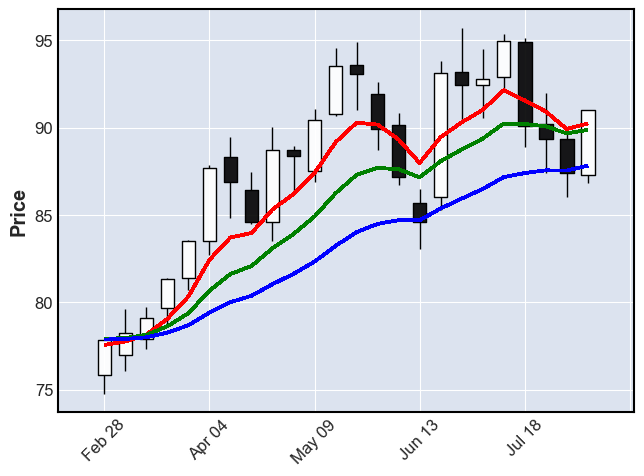

In [17]:
from plotting import PlotCurrentFormation

PlotCurrentFormation(trade_formation)

In [18]:
trade_formation

,Date,Open,High,Low,Close,EMA6,EMA12,EMA24
50,2022-02-28,75.830002,77.860001,74.779999,77.830002,77.562152,77.903023,77.870503
51,2022-03-07,77.010002,79.629997,76.080002,78.260002,77.761538,77.957942,77.901663
52,2022-03-14,77.900002,79.739998,77.309998,79.110001,78.146813,78.135182,77.998330
53,2022-03-21,79.669998,81.379997,78.769997,81.339996,79.059151,78.628231,78.265664
54,2022-03-28,81.370003,83.580002,80.730003,83.519997,80.333678,79.380810,78.686010
55,2022-04-04,83.500000,87.839996,82.730003,87.680000,82.432628,80.657608,79.405529
56,2022-04-11,88.320000,89.480003,84.830002,86.910004,83.711878,81.619515,80.005887
57,2022-04-18,86.419998,87.449997,84.500000,84.589996,83.962769,82.076512,80.372616
58,2022-04-25,84.589996,90.010002,83.529999,88.690002,85.313407,83.093972,81.038007
59,2022-05-02,88.720001,88.919998,86.360001,88.389999,86.192433,83.908746,81.626166
